In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 

* Read in data

In [2]:
df = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/probabilistic-forecasting-i-temperature/train.csv',
                 index_col=['date'],
                   parse_dates=['date'])

test = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/probabilistic-forecasting-i-temperature/test.csv',
                   index_col=['date'],
                   parse_dates=['date'])

In [3]:
df.index.min(), df.index.max() # we can see the data spans nearly two years in teh train set 
 
df = df.asfreq('15min') # set freq 

#inspect missing 

df.isna().sum()

id             0
feature_AA     0
feature_AB     0
feature_BA     0
feature_BB     0
feature_CA     0
feature_CB     0
Temperature    0
dtype: int64

<Axes: xlabel='date'>

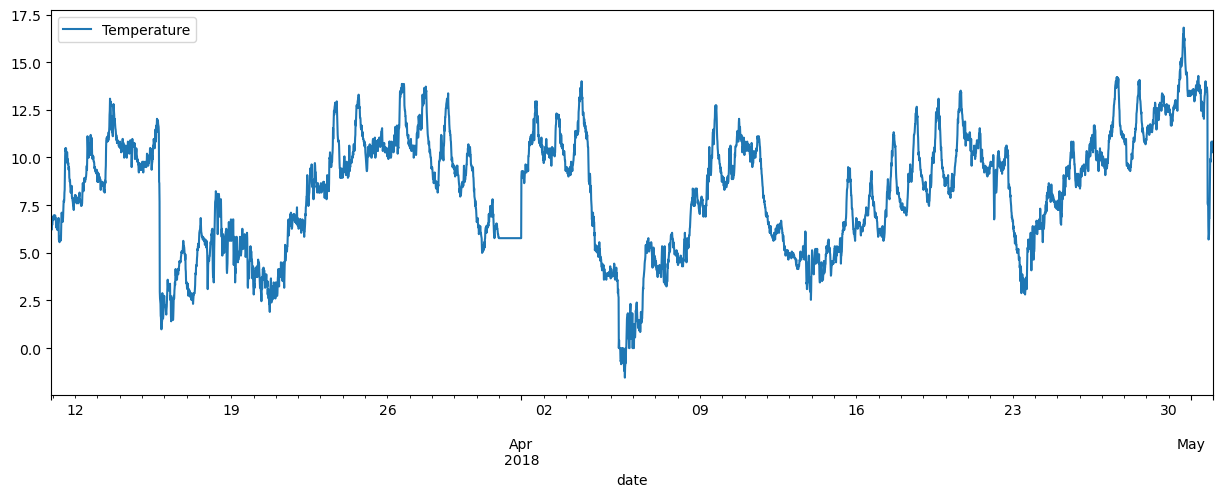

In [4]:
#plot data 

df.tail(5000).plot(y='Temperature',
                   figsize=(15,5))

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

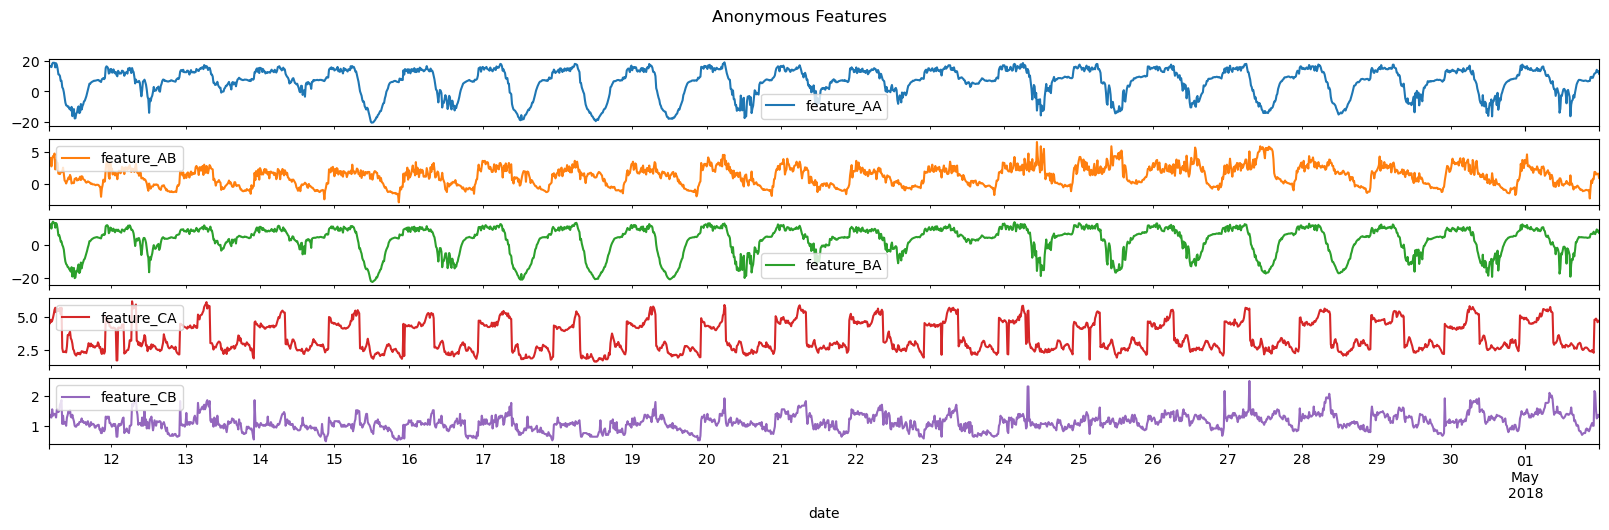

In [5]:
df.tail(2000).plot(y=['feature_AA','feature_AB','feature_BA','feature_CA','feature_CB'],
                   subplots=True,
                   title='Anonymous Features',
                   figsize=(20,5))

* We see clear seasonality and trend in both the features and our target variable. 

* Lets inspect our seasonality against various time horizons in our target variable.

In [6]:
from sktime.transformations.series.date import DateTimeFeatures

dtf = DateTimeFeatures(ts_freq='T',
                       manual_selection=['hour_of_day','day_of_week','day_of_month','month_of_year','week_of_month','quarter_of_year'],
                       keep_original_columns=True)

date_feats = dtf.fit_transform(df)

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sktime/transformations/series/date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sktime/transformations/series/date.py:448: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  DUMMIES = DUMMIES.replace(
/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sktime/transformations/base.py:612: UserWarning: Level of selected dummy variable  lower level than base ts_frequency.
  Xt = self._transform(X=X_inner, y=y_inner)


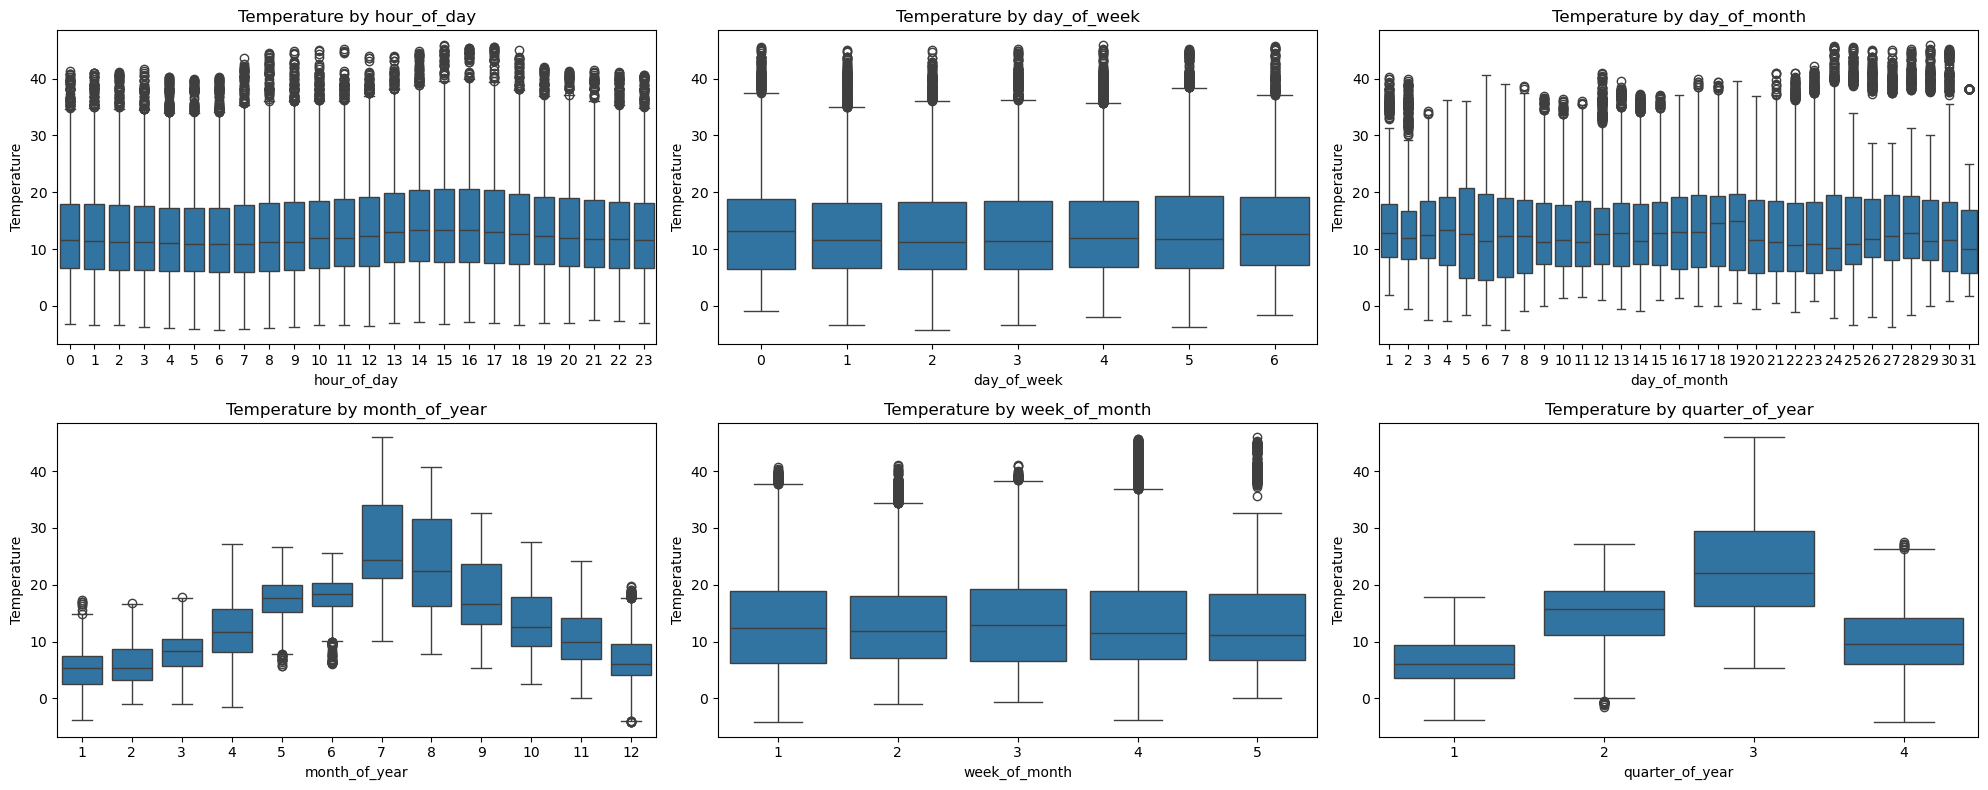

In [7]:

fig, ax = plt.subplots(figsize=(20,8),
                       ncols=3,
                       nrows=2)

ax = ax.flatten()

for i, dt_feat in enumerate(dtf.manual_selection):

    sns.boxplot(data=date_feats,
                x=dt_feat,
                y='Temperature',
                ax=ax[i]).set_title(f'Temperature by {dt_feat}')
    
fig.tight_layout()

* we see apparent seasonality around q3, months 6,7,8

* i would bet that more nuanced seasonality may be apparent if we dig a bit deeper.

In [8]:
import plotly.express as px 

dt_piv = date_feats.reset_index().pivot_table(index='month_of_year',
                                     columns='hour_of_day',
                                     values='Temperature')

px.imshow(img=dt_piv,
          title='Daily Seasonality by Month of Year')

* lets decompose the series using MSTL

In [9]:
from statsmodels.tsa.seasonal import MSTL 

# upsample the series and compute MSTL decomp 

upsamp = df.resample('h').mean()

targ = np.cbrt(upsamp['Temperature'])

mstl_decomp = MSTL(endog=targ, # transform to remove trend, we have negatives so we can't use log, log1p or boxcox
     periods=(4*24, # daily
              4*24*7, # weekly
              4*24*28, # monthly 
              4*24*28*3), # quarterly 
                  stl_kwargs={
                "trend_deg":3, # Means the seasonal smoother is fit with a moving average.
              'seasonal_deg':0}).fit()

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/statsmodels/tsa/stl/mstl.py:218: UserWarning:

A period(s) is larger than half the length of time series. Removing these period(s).



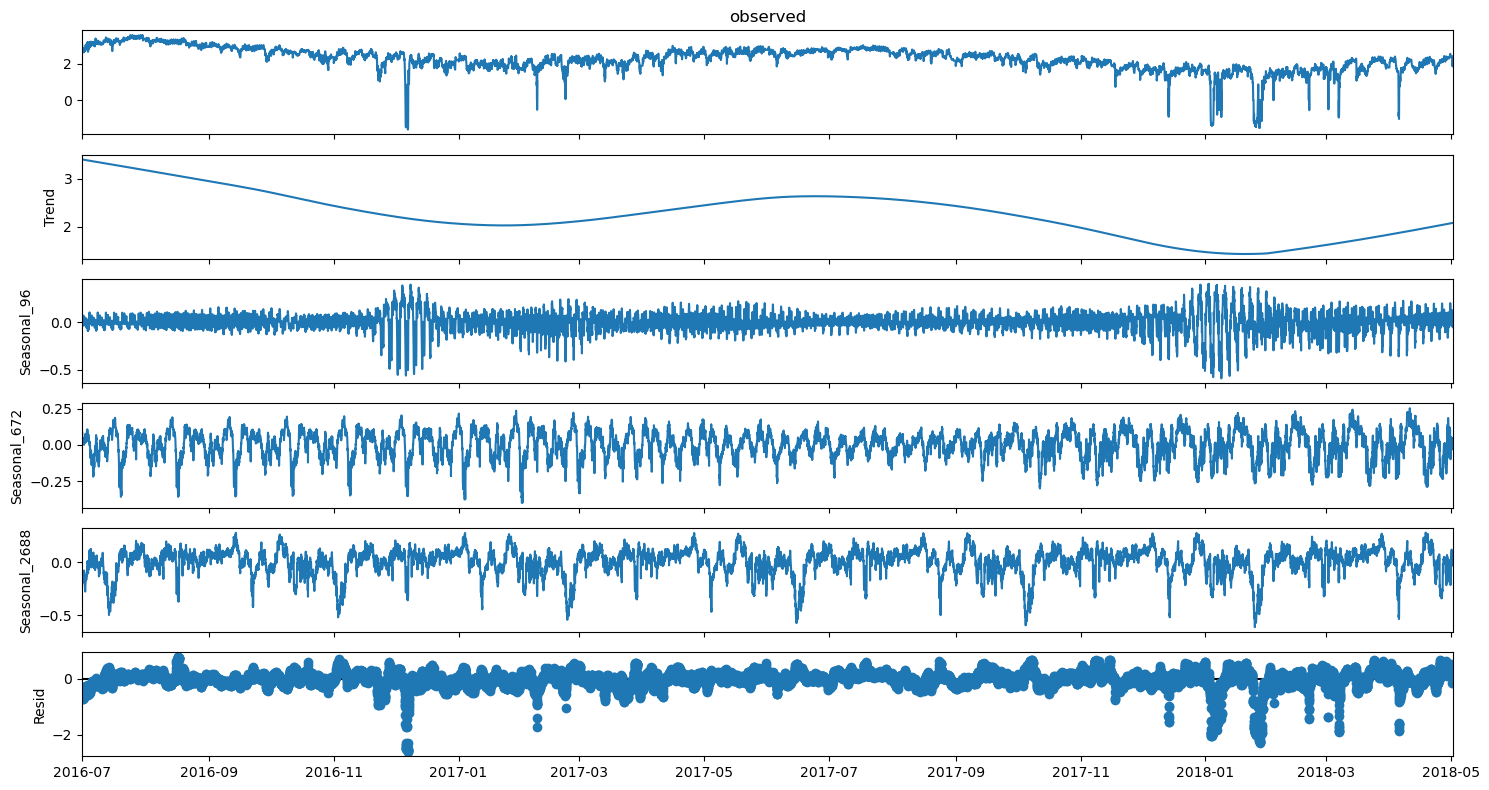

In [10]:
plt.rc('figure',figsize=(15,8))

mstl_decomp.plot()

plt.tight_layout()

* analyze residuals, check the distribution, heterskedasticity and autocorrelation

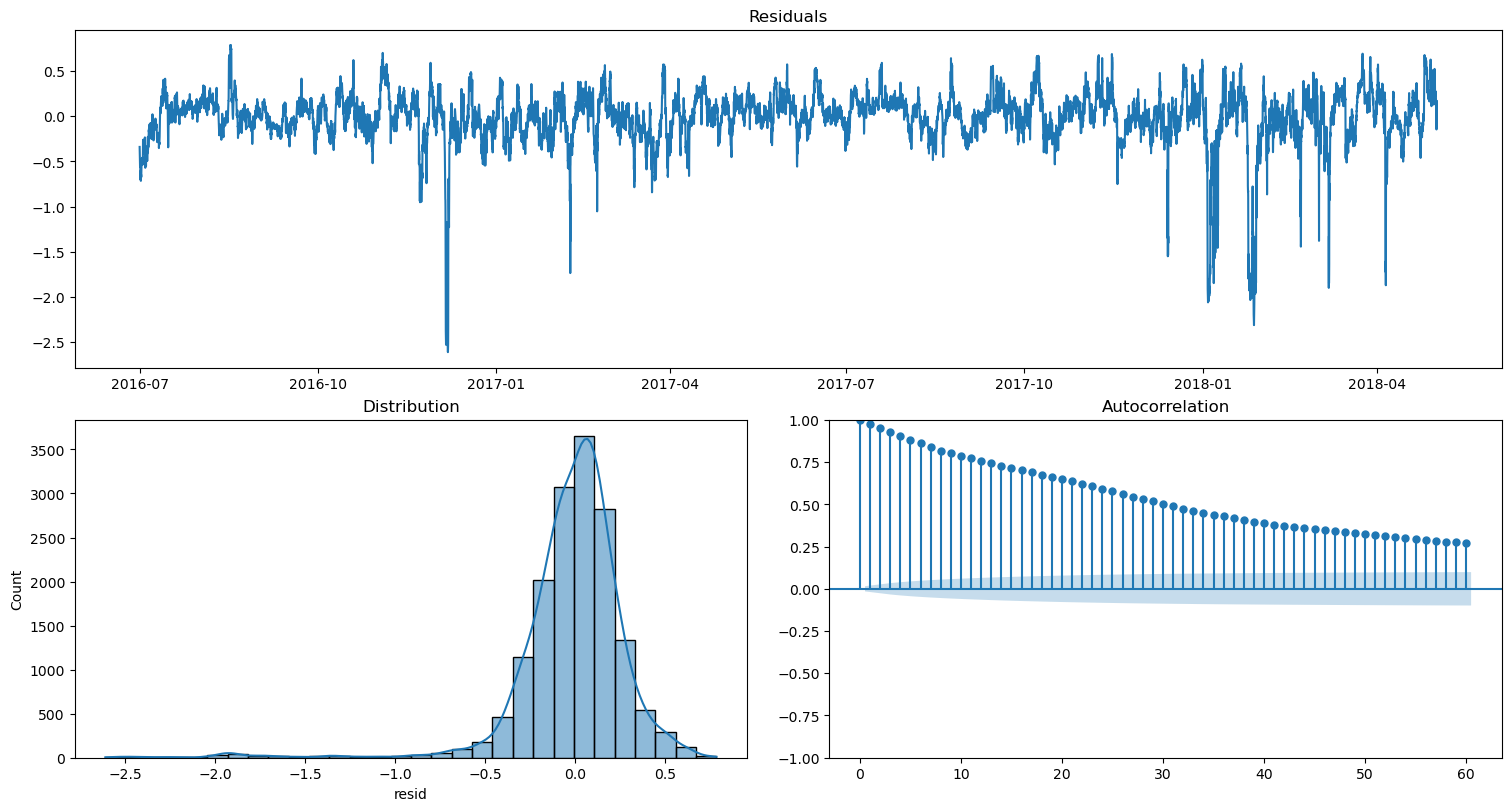

In [11]:
from skforecast.plot import plot_residuals 
from statsmodels.stats.diagnostic import het_white, het_arch,het_breuschpagan
import scipy.stats as st 

plot_residuals(mstl_decomp.resid,
               )

plt.show()

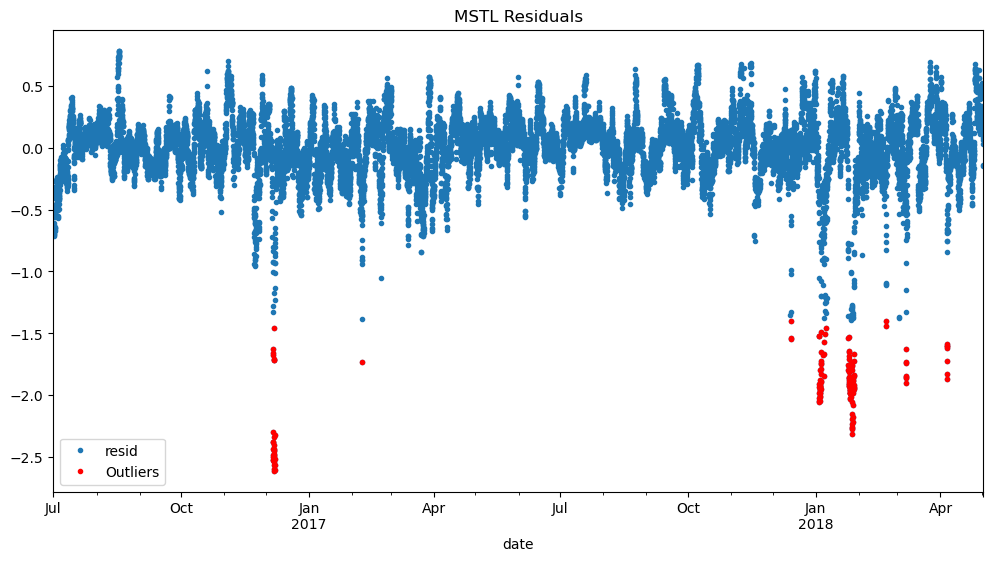

In [12]:
mstl_decomp.resid.plot(marker='.',
                linestyle=' ',
                figsize=(8,4)) # outside of a few large misses in the residuals our residuals look more like white noise, applying cube root tightened the variance, but its important to note they still contain some trend....

#lets correct these misses in the residuals 

#we can just use zscore to quickly flag these and move on 
out = st.zscore(mstl_decomp.resid).abs() > 4.5

mstl_decomp.resid.loc[out].plot(marker='.',
                                c='red',
                                linestyle=' ',
                                figsize=(12,6),
                                title='MSTL Residuals',
                                label='Outliers')

plt.legend()

In [13]:
#impute outliers and test for heteroskedasticity 

outlier_dates = np.unique(upsamp.loc[out,'Temperature'].index.date)

date_feats = date_feats.assign(date = date_feats.index.date,
                               year = date_feats.index.year)
out_df = date_feats.query('date in @outlier_dates') # slice outliers



#slice target columns only 
target_cols = [x for x in df.columns if "Temp" in x or "feature" in x]

#mean readings for all target cols
mean_temps = date_feats.groupby(['month_of_year','day_of_week','hour_of_day'],observed=True)[target_cols].mean(numeric_only=True) # get mean values of all readings for each month, dayofweek and hour, 



new_vals = (out_df
 
 .query('feature_AA == 0')
 
 .merge(mean_temps, #only fill/mark nan where all feature values == 0, otherwise we will keep the "outlier"
  
             left_on=['month_of_year','day_of_week','hour_of_day'],
  
             right_index=True,
  
             suffixes=('_old','')))[['id'] + target_cols] # new values 



#replace these with shift imputation, last year's values. This isn't sophisticated but given the large volume of data points and small # of outliers it may be ok
# i don't want to use the above method as I may have to test my model on this data due to the dataspan we have

shiftd = df.shift(4*24*365).dropna()[['Temperature']]

df = df.join(shiftd,rsuffix='_new')

df.loc[out_df.index,'Temperature'] = np.nan 

In [14]:
df['Temperature'] = df['Temperature'].fillna(df['Temperature_new']) #this fills 2017-2018 values 

df.loc[new_vals.index,target_cols] = np.nan # set missing cvalues to NaN 

In [15]:
df = df.fillna(new_vals) # fill nan feature and temp values from december 2016 

df = df.drop(columns=["Temperature_new"]).ffill() #forward fill our last, single day point outlier and drop the temp new column

<Axes: title={'center': 'New Data (No Outliers)'}, xlabel='date', ylabel='Temp'>

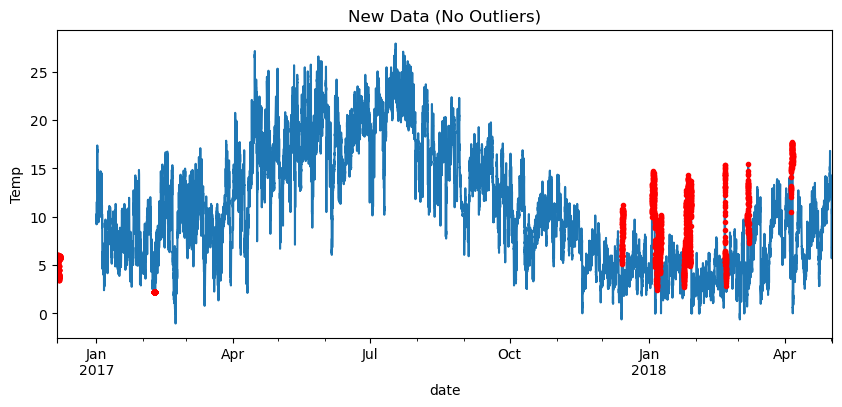

In [16]:
# lets plot our data after handling outliers and highlight them 

ax = df.loc['2017':,'Temperature'].plot(title='New Data (No Outliers)',
                       xlabel='Date',
                       ylabel='Temp',
                       figsize=(10,4))

df.loc[out_df.index,'Temperature'].plot(marker='.',
                                        linestyle=' ',
                                        c='r',
                                        ax=ax,
                                        label='Former Outliers')

In [17]:
from statsmodels.tsa.stattools import adfuller, kpss 

kpss_res = kpss(df['Temperature'])

adf_res = adfuller(df['Temperature'])

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/862436069.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [18]:
print(f'The KPSS P_val is : {kpss_res[1]:.4f}')

print(f'The adfuller P_val is: {adf_res[1]:.4f}')

print('this points to the series potentially being stationary, but given the strong trend we see, we can conclude rather that it only doesnt have a unit root...')

The KPSS P_val is : 0.0100
The adfuller P_val is: 0.0004
this points to the series potentially being stationary, but given the strong trend we see, we can conclude rather that it only doesnt have a unit root...


In [19]:

#take first difference 

fd = df['Temperature'].diff().dropna() 

kpss_res = kpss(fd)

adf_res = adfuller(fd)

print(f'The KPSS P_val is : {kpss_res[1]:.4f}')

print(f'The adfuller P_val is: {adf_res[1]:.10f}')

/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/843494220.py:5: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




The KPSS P_val is : 0.1000
The adfuller P_val is: 0.0000000000


* the first difference didn't change our outcome of the adfuller test, but given the trend that was present I feel more comfortable with the result, also we see the KPSS p-value went up, which is providing stronger evidence of stationarity.

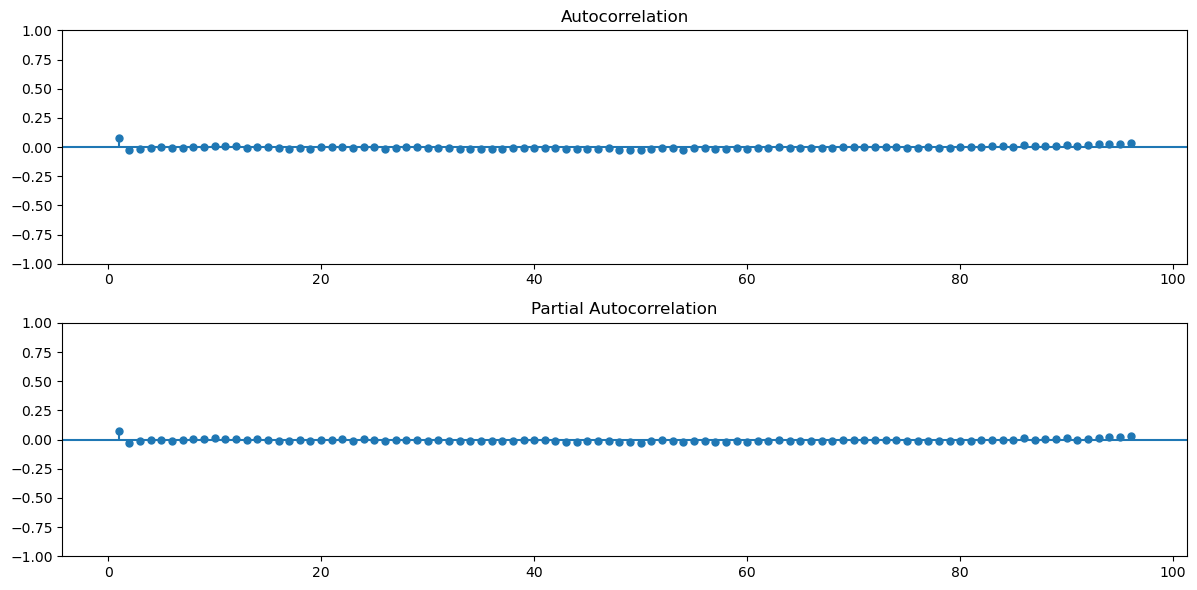

In [20]:
# lets detrend the data and plot acf, pacf

from statsmodels.graphics.tsaplots import plot_acf,plot_ccf, plot_pacf

fig, ax = plt.subplots(figsize=(12,6),
                       nrows=2)

plot_acf(fd,
         zero=False,
         ax=ax[0],
         lags=4*24, # 1 day of lags 
         )

plot_pacf(fd,
         zero=False,
         ax=ax[1],
         lags=4*24, # 1 day of lags 
         )

plt.tight_layout()

* lets take a step back and see what we have here.... 

* Lag 1 Auto Correlation and PACF
* Quarterly, Yearly seasonality (maybe a bit of daily seasonality but not much) 
* Strong Trend Component


    Now we need to look for cross correlations.

In [21]:
#AB, BA, CA have strong seasonal components, while CB has a weaker/more irregular seasonal pattern... 

for feat  in df.filter(like='feature').columns: 

    ts_diffd = df[feat].diff().dropna() 

    print(f'STATIONARITY TEST FOR {feat}')

    adf_res = adfuller(ts_diffd,regression='ct')

    kpss_res = kpss(ts_diffd,regression='ct')

    print(f'ADF P-val: {adf_res[1]:.4f}')

    print(f'KPSS Res: {kpss_res[1]:.4f}')

STATIONARITY TEST FOR feature_AA


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/737395193.py:11: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF P-val: 0.0000
KPSS Res: 0.1000
STATIONARITY TEST FOR feature_AB


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/737395193.py:11: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF P-val: 0.0000
KPSS Res: 0.1000
STATIONARITY TEST FOR feature_BA


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/737395193.py:11: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF P-val: 0.0000
KPSS Res: 0.1000
STATIONARITY TEST FOR feature_BB


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/737395193.py:11: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF P-val: 0.0000
KPSS Res: 0.1000
STATIONARITY TEST FOR feature_CA


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/737395193.py:11: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




ADF P-val: 0.0000
KPSS Res: 0.1000
STATIONARITY TEST FOR feature_CB
ADF P-val: 0.0000
KPSS Res: 0.1000


/var/folders/k6/3y0j37d96lqf05r_8yyfcqvh0000gn/T/ipykernel_71102/737395193.py:11: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




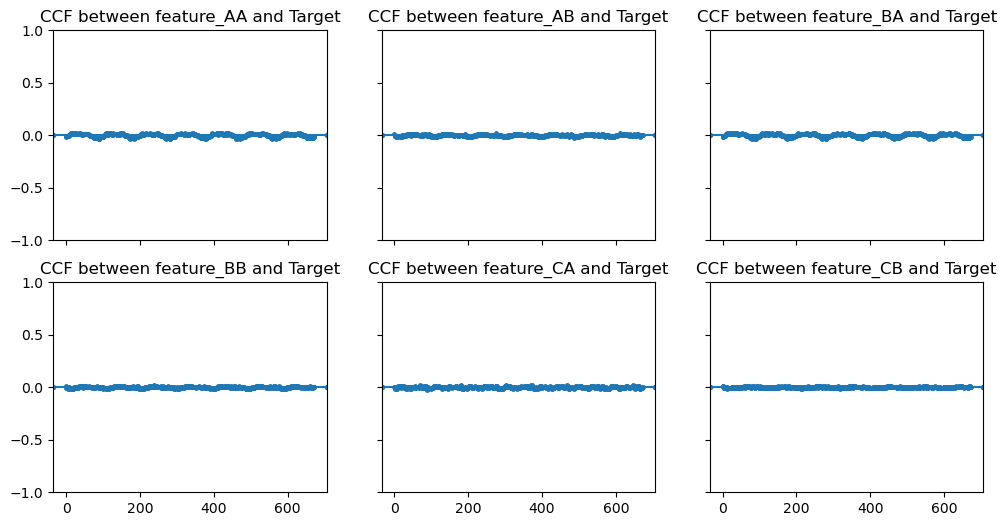

In [22]:
from statsmodels.graphics.tsaplots import plot_ccf 

fig, ax = plt.subplots(figsize=(12,6),
                       ncols=3,
                       nrows=2,
                       sharey=True,
                       sharex=True)

ax = ax.flatten() 

for i,feat  in enumerate(df.filter(like='feature').columns): 

    ts_diffd = df[feat].diff().dropna() 

    #plot ccf, we must make each series stationary to find any meaningful cross-correlations 

    plot_ccf(x=ts_diffd,y=fd,title=f'CCF between {feat} and Target',ax=ax[i],
             lags=4*24*7, # one week of lags 
             alpha=.01,
             marker='.',
             fft=True)  # 99% conf # it looks like AB, BA and AA could have stronger relationship with our series than the others.... 

* we can get a better understanding of granger causality which will help quantify any linear relationships present in the series'.

 Here we will focus in on the F statistics as it looks like all of our features have some sort of cross correlation present.

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

res_dict = {} 

for i,feat  in enumerate(df.filter(like='feature').columns): 

    ts_diffd = df[feat].diff().dropna() 

    comb_ts = pd.concat([ts_diffd,fd],axis=1)

    granger_res = grangercausalitytests(x=comb_ts,maxlag=[1,4*24,4*24*7]) # test for causality at lag 1, lag 1-day and lag 1-week

    res_dict[feat] = granger_res


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4705 , p=0.0004  , df_denom=64315, df_num=1
ssr based chi2 test:   chi2=12.4711 , p=0.0004  , df=1
likelihood ratio test: chi2=12.4699 , p=0.0004  , df=1
parameter F test:         F=12.4705 , p=0.0004  , df_denom=64315, df_num=1

Granger Causality
number of lags (no zero) 96
ssr based F test:         F=1.9600  , p=0.0000  , df_denom=64030, df_num=96
ssr based chi2 test:   chi2=188.7271, p=0.0000  , df=96
likelihood ratio test: chi2=188.4503, p=0.0000  , df=96
parameter F test:         F=1.9600  , p=0.0000  , df_denom=64030, df_num=96

Granger Causality
number of lags (no zero) 672
ssr based F test:         F=0.9860  , p=0.5945  , df_denom=62302, df_num=672
ssr based chi2 test:   chi2=676.8736, p=0.4401  , df=672
likelihood ratio test: chi2=673.2997, p=0.4786  , df=672
parameter F test:         F=0.9860  , p=0.5945  , df_denom=62302, df_num=672

Granger Causality
number of lags (no zero) 1
ssr based F test:    

In [24]:
for key in df.filter(like='feature').columns: 

    for lag in [1,96,96*7]:

        #print fstatistic at key-lag
        fstat = res_dict[key][lag][0]['ssr_ftest'][0]

        #print p-value at key-lag
        p_val = res_dict[key][lag][0]['ssr_ftest'][1]

        print(f"GRANGER RESULTS FOR {key}")

        print(f'F-Statistic at Lag {lag} is: {fstat:.2f}')

        print(f'P-val at Lag {lag} is: {p_val:.4f}')

        print()

GRANGER RESULTS FOR feature_AA
F-Statistic at Lag 1 is: 12.47
P-val at Lag 1 is: 0.0004

GRANGER RESULTS FOR feature_AA
F-Statistic at Lag 96 is: 1.96
P-val at Lag 96 is: 0.0000

GRANGER RESULTS FOR feature_AA
F-Statistic at Lag 672 is: 0.99
P-val at Lag 672 is: 0.5945

GRANGER RESULTS FOR feature_AB
F-Statistic at Lag 1 is: 0.05
P-val at Lag 1 is: 0.8268

GRANGER RESULTS FOR feature_AB
F-Statistic at Lag 96 is: 2.75
P-val at Lag 96 is: 0.0000

GRANGER RESULTS FOR feature_AB
F-Statistic at Lag 672 is: 1.11
P-val at Lag 672 is: 0.0298

GRANGER RESULTS FOR feature_BA
F-Statistic at Lag 1 is: 16.68
P-val at Lag 1 is: 0.0000

GRANGER RESULTS FOR feature_BA
F-Statistic at Lag 96 is: 1.82
P-val at Lag 96 is: 0.0000

GRANGER RESULTS FOR feature_BA
F-Statistic at Lag 672 is: 0.98
P-val at Lag 672 is: 0.6073

GRANGER RESULTS FOR feature_BB
F-Statistic at Lag 1 is: 0.00
P-val at Lag 1 is: 0.9761

GRANGER RESULTS FOR feature_BB
F-Statistic at Lag 96 is: 2.43
P-val at Lag 96 is: 0.0000

GRANGER RE

* we can see that given the f-stat and p-values of each feature that BA, CB and AA are predictive at lag 1. 

We may still utilize the other features but when modeling lets select these. They show some significant effect at all lags. We will use lag 1 and a rolling window of 1 day, 1 week for them.

In [25]:
from mlforecast import MLForecast
from sklearn.linear_model import Ridge, Lasso
from mlforecast.target_transforms import Differences 
from mlforecast.lag_transforms import RollingMean, RollingStd, SeasonalRollingMean
from sktime.transformations.series.summarize import WindowSummarizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from mlforecast.utils import PredictionIntervals

models = {'Ridge':make_pipeline(MinMaxScaler(), Ridge(alpha=1)),
          'Lasso':make_pipeline(MinMaxScaler(),Lasso(alpha=.001))}


lags = [1,2,3, 96,96*7]

mlf = MLForecast(
    models = models,
    freq = '15min',
    lags=lags,
    #date_features=['quarter','month','year'],
    num_threads=8,
    target_transforms=[Differences([1])],
   lag_transforms={1:[RollingMean(window_size=96,min_samples=1),
                      RollingStd(window_size=96,min_samples=1),
                      SeasonalRollingMean(season_length=4,window_size=24,min_samples=1),
                       SeasonalRollingMean(season_length=96,window_size=7,min_samples=1),
                       SeasonalRollingMean(season_length=96*7,window_size=4,min_samples=1),
                       ]
                       }
)

* I tried differencing the series, this only worked well for Lasso...

<Axes: title={'center': 'Preprocessed Target'}, xlabel='ds'>

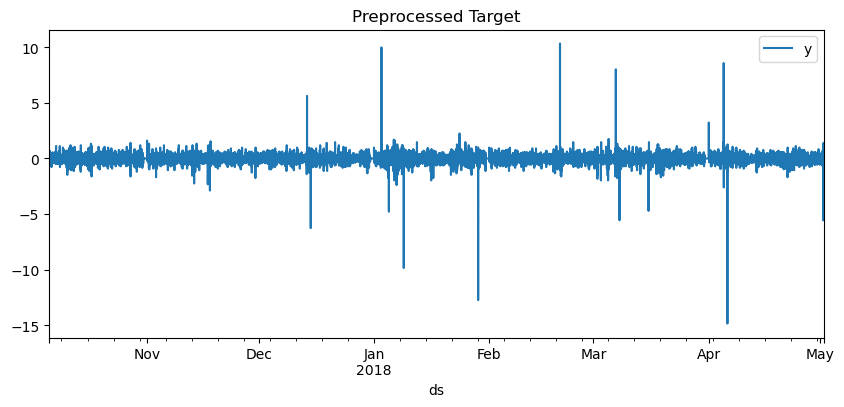

In [26]:
#prep ts for nixtla 

uni = df[['Temperature']].reset_index().rename(columns={'date':'ds',
                                                  'Temperature':'y'}).assign(uid=1) # assign unique id so nixtla can univariate fcst 

# lets get a univariate baseline forecast first... 

pre_df = mlf.preprocess(uni,
               id_col='uid')

#lets just plot our preprocess y to give it a look 

pre_df.tail(20000).plot(y='y',
            x='ds',
            figsize=(10,4),
            title='Preprocessed Target') # interesting we see some large fluctuations... they seem somewhat random...

* create fourier features 

In [27]:
from utilsforecast.feature_engineering import fourier, trend, pipeline 
from functools import partial 

features = [trend,
            partial(fourier,season_length=4,k=1),
            partial(fourier,season_length=96*28*3,k=1)
            ]

horizon = len(test)

#create feature pipeline for trend and periodic components 
df_fourier,fut_h = pipeline(

features = features,

freq='15min',

h=horizon, # set as horizon, although we don't need these features for now 

df=uni,

id_col='uid')

* fitting a univariate forecasting model with fourier features and our lag/window features.

In [28]:
mlf.fit(df_fourier,
        as_numpy=True,
        id_col='uid')

#perform cross validation on 3 different horizons and evaluate the fit 
quantiles = [10, 20, 30, 40, 50, 60, 70, 80, 90,95]

cv_uni = mlf.cross_validation(
    df= df_fourier,
    h = horizon,
    step_size=horizon,
    n_windows=3,
    id_col='uid',
    refit=False,
    as_numpy=True, # speeds up training dramatically 
prediction_intervals=PredictionIntervals(h=horizon),
level=quantiles,
static_features=[])

* define a function to evaluate my cross validation using various metrics

* I believe mqloss is very similar to CRPS, but I could be wrong...

In [29]:
from utilsforecast.losses import * 
from utilsforecast.evaluation import evaluate

def eval_cv(cv_df, models): 

    metrics = [rmse,
           # partial(mase,seasonality=4*24),
            mae,
            partial(scaled_crps,quantiles = quantiles),
          partial(mqloss,quantiles=quantiles)
            ]

    uni_eval = evaluate(cv_df,
            metrics=metrics,
            models=models,
            train_df=cv_df,
            id_col='cutoff',
            level=quantiles

    )

    #display(uni_eval)
    uni_eval.groupby('metric').mean().plot.barh(title="Univariate Model Evaluation",
                                        y=models,
                                        xlabel='Error',
                                    ylabel='Model Error',
                                        grid=True,
                                        figsize=(8,4),
                                        edgecolor='black')

    display(uni_eval.groupby('metric')[models].mean())

    return uni_eval

,Ridge,Lasso
metric,,
mae,7.938285,3.251419
mqloss,3.217855,1.132053
rmse,9.472156,3.831673
scaled_crps,1.172947,0.411931


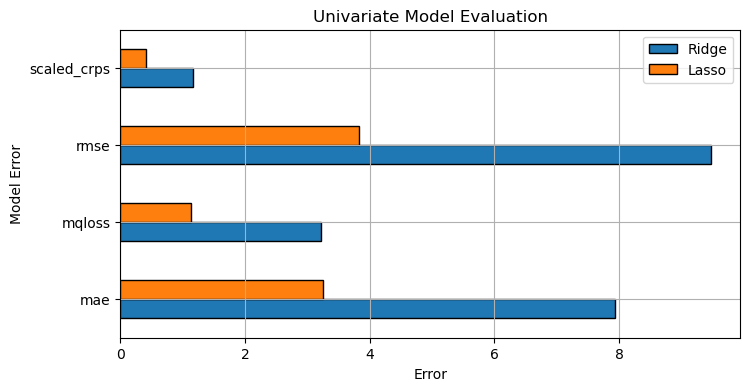

In [30]:
models = ['Ridge','Lasso']

eval_df = eval_cv(cv_uni,models)
# the linear model does much better in a simulated 28 days ahead forecast, we are above 1 MASE though meaning we are worse than a naive weekly forecast....

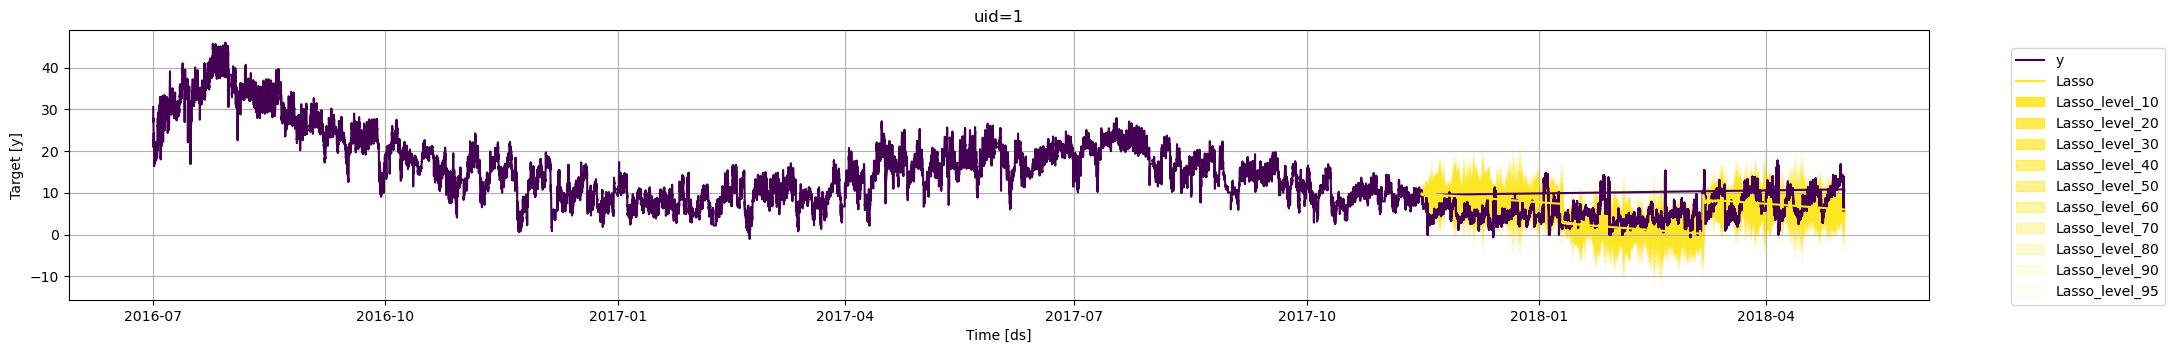

In [31]:
from utilsforecast.plotting import plot_series

plot_series(df=uni,
            id_col='uid',
            forecasts_df=cv_uni,
            models=['Lasso'],
            level=quantiles)

* We fit an MSTL forecaster, here I notice that using larger seasonalities didn't work well (possibly overfit?) But the strongest seasonal pattern is daily..

In [32]:
from statsforecast.models import MSTL 
from statsforecast import StatsForecast

sf = StatsForecast(models=[MSTL(season_length=(96,
                                               96*28))],
                                               freq='15min',
                                               n_jobs=-1)

sfcv = sf.cross_validation(
    h=horizon,
    id_col='uid',
    df=uni,
    n_windows=3,
    refit=False,
    step_size=horizon,
    prediction_intervals=PredictionIntervals(h=horizon),
    level=quantiles
)

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/statsforecast/core.py:485: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



,MSTL
metric,
mae,3.031505
mqloss,2.411787
rmse,3.607688
scaled_crps,0.872688


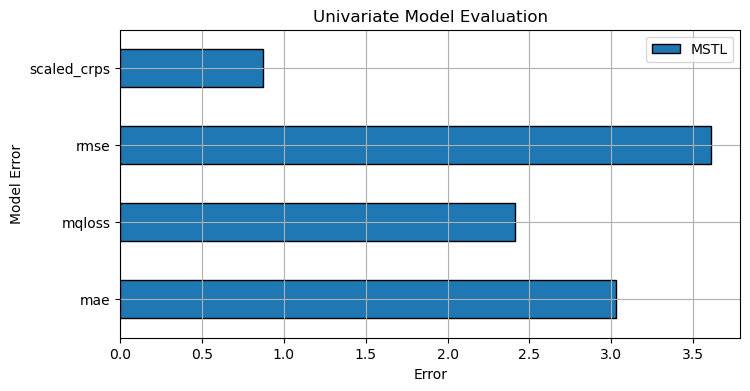

In [33]:
mstl_eval = eval_cv(cv_df=sfcv,models=['MSTL'])

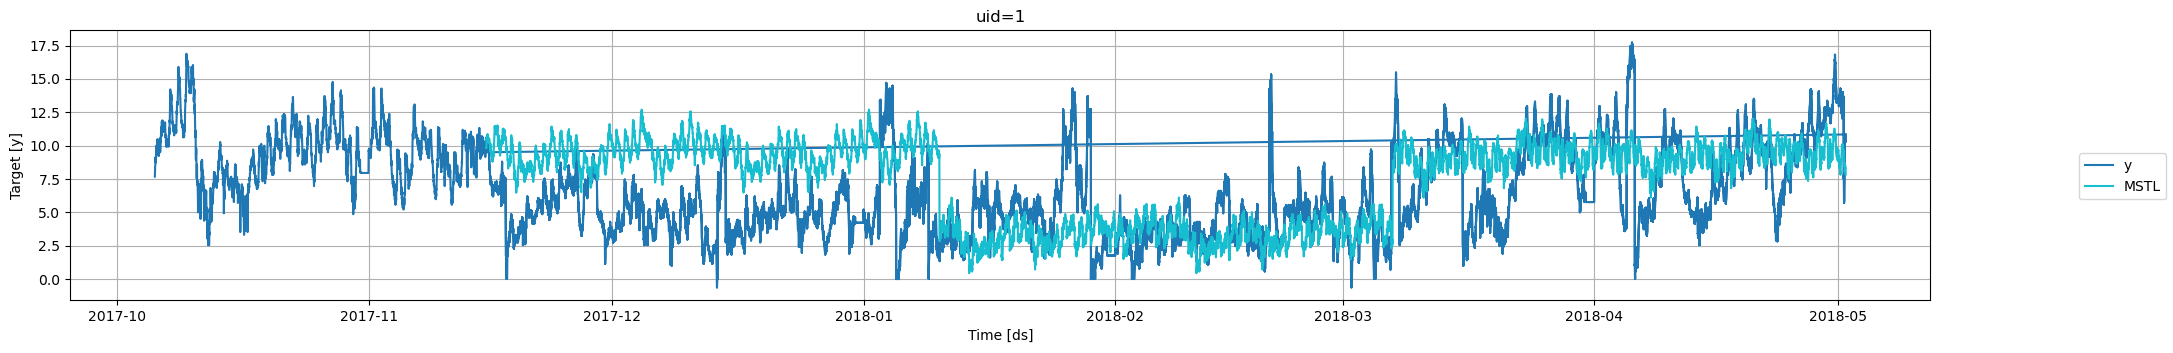

In [34]:
plot_series(df=uni,
            id_col='uid',
            forecasts_df=sfcv.reset_index(),
            models=['MSTL'],
            palette='tab10',
            #level=quantiles,
            max_insample_length=20000)

In [35]:
new = pd.concat([cv_uni.filter(like='Lasso'),sfcv[['MSTL']].reset_index()],axis=1)

new = new.drop('Lasso',axis=1).rename(columns={'MSTL':"Lasso"}).assign(ds = cv_uni.ds)

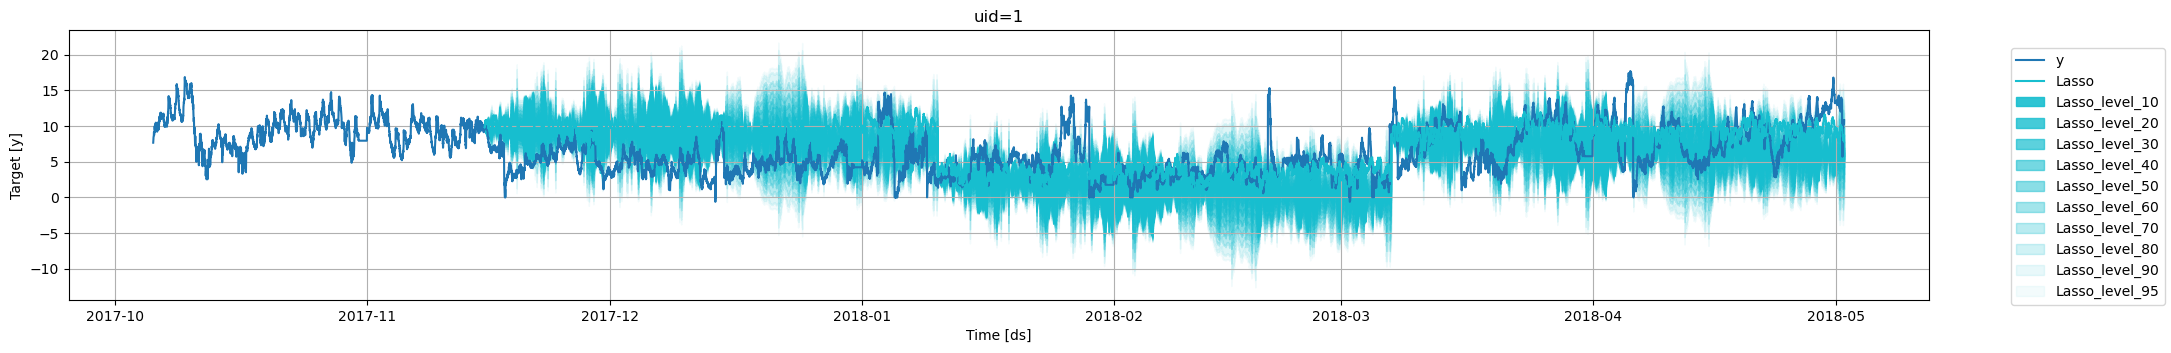

In [36]:
plot_series(df=uni,
            id_col='uid',
            forecasts_df=new,
            models=['Lasso'],
            palette='tab10',
            level=quantiles,
            max_insample_length=20000)

* now lets add in the features that may have predictive power.

<Axes: >

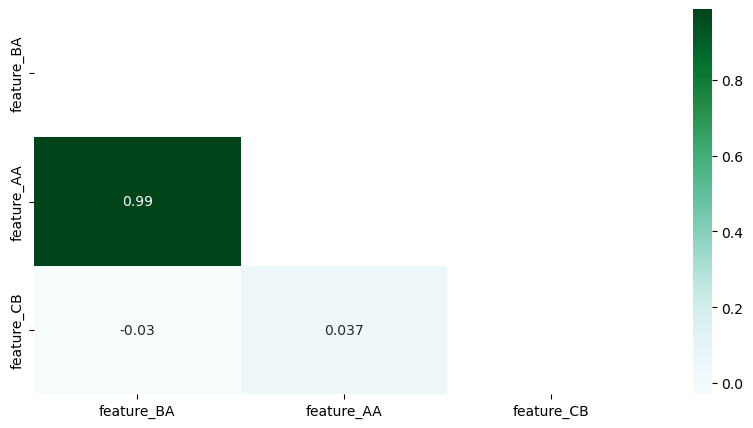

In [37]:
ext_feats = df[['feature_BA','feature_AA','feature_CB']] # join in features of interest

feat_corr = ext_feats.corr()

plt.rc('figure',figsize=(10,5))
sns.heatmap(feat_corr,
            mask=np.triu(np.ones_like(feat_corr)),
            annot=True,
            cmap='BuGn') 

# it looksl ike aA abd BA are perfectly correlated... BA had a higher F stat in my granger test so we will use it...

* we'll use PCA to decompose these features and see if they add to the performance. 

In [38]:
ext_feats_trns = WindowSummarizer(target_cols=['feature_BA','feature_AA','feature_CB'],
                                  
    lag_feature={
    'lag':[1],
   # 'mean':[[1,96]],
   # 'std':[[1,96]],
},
  truncate='bfill')

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import set_config 

set_config(transform_output='pandas')

pca_pipe = make_pipeline(ext_feats_trns,
    StandardScaler(),
              PCA(n_components=.99,
                  random_state=42))

ext_pca = pca_pipe.fit_transform(ext_feats)

#join in features 
fourier_ext = df_fourier.merge(ext_pca,left_on='ds',right_index=True)

fourier_ext.head()

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/sktime/transformations/series/summarize.py:299: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



,ds,y,uid,trend,sin1_4,cos1_4,sin1_8064,cos1_8064,pca0,pca1
0,2016-07-01 00:00:00,30.531000,1,1.0,1.000000e+00,-4.371139e-08,0.000779,1.000000,0.477966,0.870243
1,2016-07-01 00:15:00,30.459999,1,2.0,-8.742278e-08,-1.000000e+00,0.001558,0.999999,0.477966,0.870243
2,2016-07-01 00:30:00,30.038000,1,3.0,-1.000000e+00,1.192488e-08,0.002337,0.999997,0.495657,0.971961
3,2016-07-01 00:45:00,27.013000,1,4.0,1.748456e-07,1.000000e+00,0.003117,0.999995,0.496424,0.820672
4,2016-07-01 01:00:00,27.787001,1,5.0,1.000000e+00,-3.377662e-07,0.003896,0.999992,0.496424,0.820672


,Lasso,RF
metric,,
mae,3.368866,3.124269
mqloss,1.543184,1.112652
rmse,3.945058,3.724559
scaled_crps,0.444234,0.358194


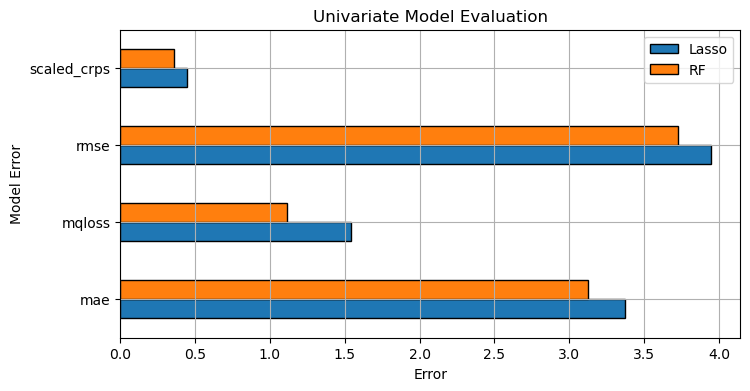

In [39]:
from mlforecast import MLForecast
from sklearn.linear_model import Ridge,Lasso 
from lightgbm import LGBMRegressor
from mlforecast.target_transforms import Differences,LocalStandardScaler 
from mlforecast.lag_transforms import RollingMean, RollingStd, SeasonalRollingMean,ExponentiallyWeightedMean
from sktime.transformations.series.summarize import WindowSummarizer
from xgboost import XGBRFRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

models = {
          'Lasso':Lasso(alpha=.1),
          'RF':XGBRFRegressor(num_parallel_tree=100)}

# lets adjust our window features to mimic the MSTL seasonal periods we observed 
sp = [4*24, # daily
              4*24*7, # weekly
              4*24*28, # monthly 
              4*24*28*3], # quarterly 

lags = [1,2,3, 96,96*7]

mlf = MLForecast(
    models = models,
    
    freq = '15min',
    lags=lags,

    date_features=['month'],
    num_threads=8,

    target_transforms=[LocalStandardScaler()],

   #lag_transforms={1:[RollingMean(window_size=96,min_samples=1), # daily moving average and std 
                      
     #                 ExponentiallyWeightedMean(alpha=.4), #EWM
#
        #              SeasonalRollingMean(season_length=sp[0][0],window_size=7,min_samples=1), # 7 days of daily averages 

         #              SeasonalRollingMean(season_length=sp[0][1],window_size=8,min_samples=1), # 8 weeks of weekly averages 

            #          RollingMean(window_size=sp[0][2],min_samples=1), # monthly average 

                #       RollingMean(window_size=sp[0][3],min_samples=1) #quarterly average
                 #      ]
                 #      }
)
ext_feats = mlf.cross_validation(
    df= fourier_ext,
    h = horizon,
    n_windows=4,
    id_col='uid',
    as_numpy=True, # speeds up training dramatically 
    prediction_intervals=PredictionIntervals(h=horizon),
  level=quantiles, 
  static_features=[]
)

eval_cv_ext = eval_cv(ext_feats,models=['Lasso','RF'])

* given the low error seen by random forest, lets go ahead and utilize it to forecast. 

* Lasso gives a slightly lower error but is a very naive forecast, so I would rather try and tune the RandomForest to minimize our multi-quantile loss in hopes we get a more robust end result.

* lets examine our CV coefficients and look at important features in the model.

<Axes: title={'center': 'RF Feature Importance Coefficients'}, xlabel='Feature Importance', ylabel='Feature Name'>

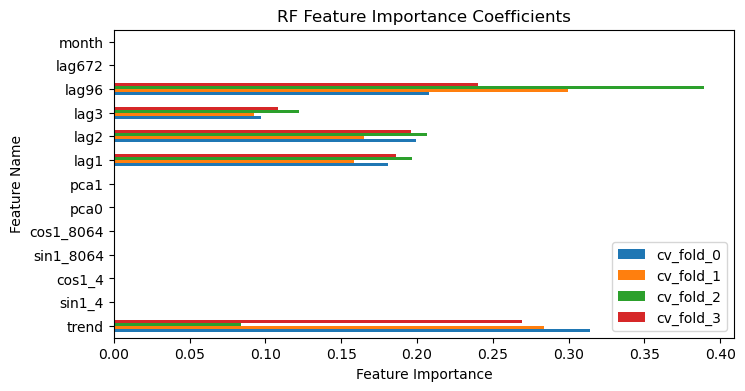

In [40]:
#pull feature names 
feats_in = mlf.preprocess(df=fourier_ext.sort_values(by='ds'),id_col='uid').drop(columns=['ds','y','uid']).columns

coef_list = []

for i in range(4): 
    
    model_coef = mlf.cv_models_[i]['RF'].feature_importances_

    coefs = pd.Series(index=feats_in,
                      data=model_coef)
    
    coef_list.append(coefs)

rf_imps = pd.concat(coef_list,axis=1)

rf_imps.columns = ['cv_fold_' + str(i) for i in rf_imps.columns]

rf_imps.plot(kind='barh',
                 title='RF Feature Importance Coefficients',
                 xlabel='Feature Importance',
                 ylabel='Feature Name',
                 figsize=(8,4))



* for our final model we will eliminate the sin/cos/trend components. 

* the linear model doesn't need a trend component (we detrended using differencing)
* the fourier terms simply don't contribute much to the model.

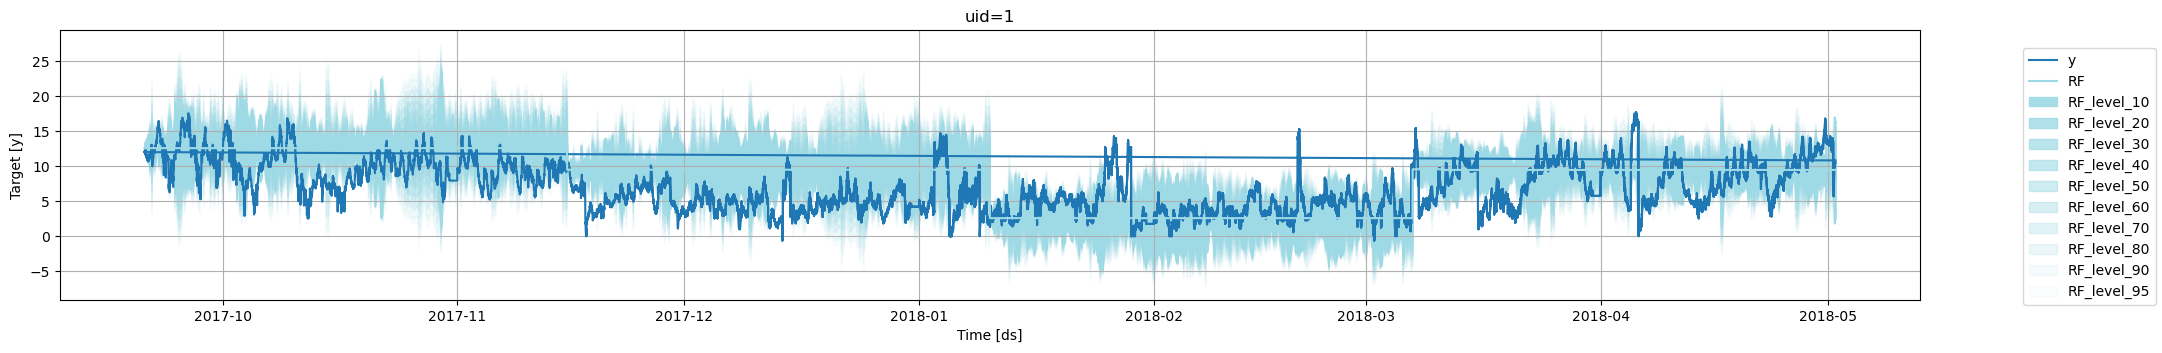

In [41]:
from utilsforecast.plotting import plot_series
plt.style.use('default')  # You can also try 'fivethirtyeight' or 'classic'

plot_series(df=uni,
            forecasts_df=ext_feats,
            id_col='uid',
            models=['RF'],
            palette='tab20',
            max_insample_length=15000,
            level=quantiles,
            )

# ensembling random forest and MSTL's point predictions, not bad

In [42]:
new = ext_feats.merge(sfcv[['ds','MSTL']],
                on='ds')

new = new.drop('RF',axis=1).assign(RF = new[['RF','MSTL']].median(axis=1))

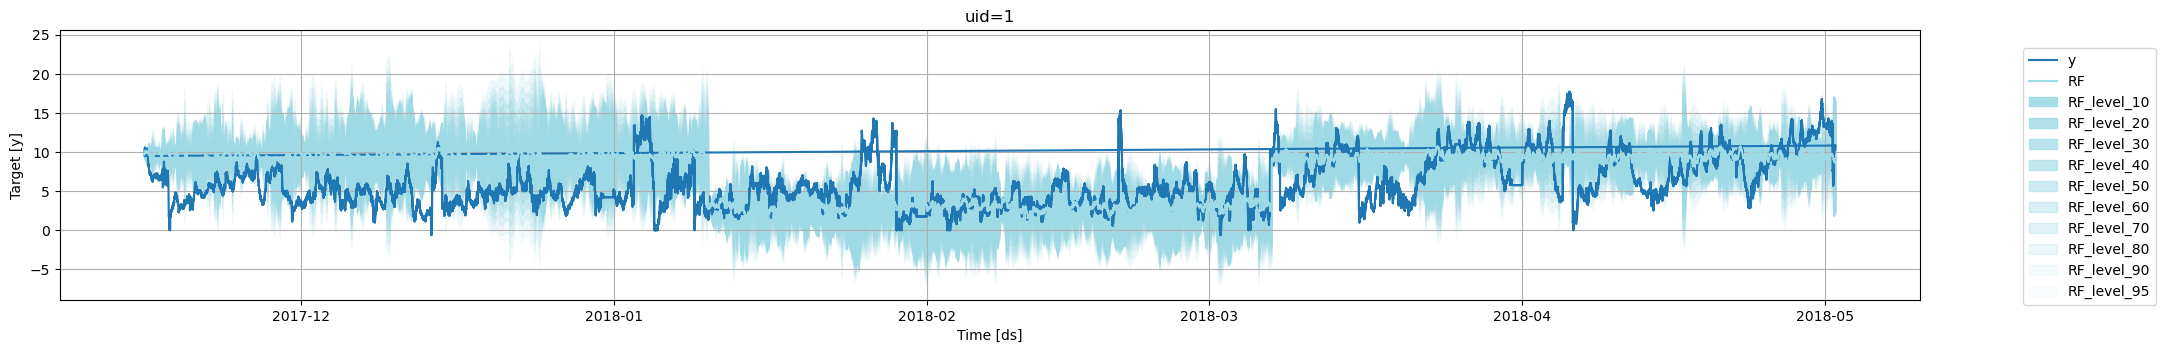

In [43]:
plot_series(df=uni,
            forecasts_df=new,
            id_col='uid',
            models=['RF'],
            palette='tab20',
            max_insample_length=15000,
            level=quantiles,
            )

* train final model and predict ahead 

In [44]:
features = [trend,
            partial(fourier,season_length=4,k=1),
        #  partial(fourier,season_length=96,k=1),
           partial(fourier,season_length=96*28*3,k=1),
          # partial(fourier,season_length=96*365,k=1)
            #partial(fourier,season_length=96*7,k=2)
            ]

horizon = len(test)

#create feature pipeline for trend and periodic components 
df_fourier_new,fut_h= pipeline(

features = features,

freq='15min',

h=horizon,

df=uni,

id_col='uid')

pred_intervals = PredictionIntervals(h=horizon,                                
            n_windows=3)

* we will ensemble our two best models, random forest using conformal predictions and external features + MSTL to capture seasonality 

In [45]:
mlf.fit(fourier_ext,
        id_col='uid',
        prediction_intervals=pred_intervals,
        as_numpy=True,
        static_features=[]
        )

sf.fit(
    id_col='uid',
    df=uni,
   # prediction_intervals=PredictionIntervals(h=horizon),
)

#PREDICT 

pca_feats_test = pca_pipe.transform(test[ext_feats_trns.target_cols]) # create pca features on test set, random forest gets fourier series, PCA of ext feats and rolling features 

fut_h_rf = fut_h.merge(pca_feats_test,
                    left_on='ds',
                    right_on='date')

In [46]:
test_pred_rf = mlf.predict(h=len(test),
            level=quantiles,
            X_df=fut_h_rf,
            )


test_pred_mstl = sf.forecast(h=len(test),
                           # level=quantiles
                            )

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/statsforecast/core.py:467: FutureWarning:

The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.

/opt/anaconda3/envs/new_env/lib/python3.9/site-packages/statsforecast/core.py:485: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



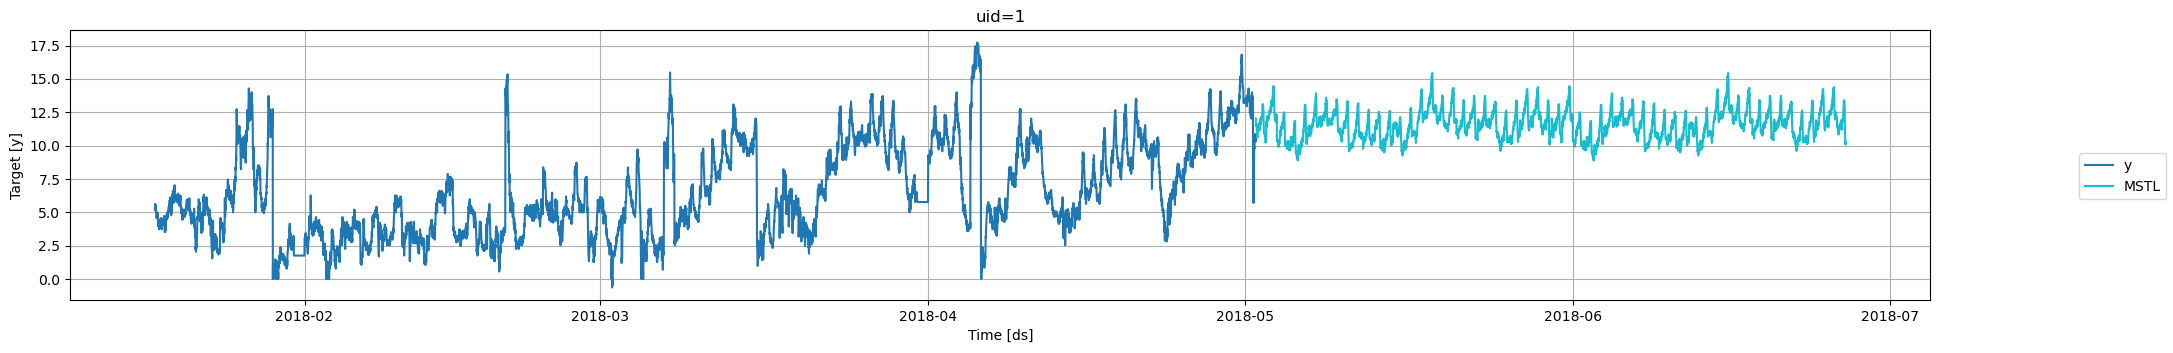

In [53]:
plot_series(df=uni,
            forecasts_df=test_pred_mstl.reset_index(),
            id_col='uid',
            models=['MSTL'],
            palette='tab10',
            max_insample_length=10000,
            #level=quantiles,
            )

In [48]:
def make_submission(filtered_df,model):
    #'''return submission dataframe in desired format for model of choice'''

    quantile_mapping = {
    95: ['0.025', '0.975'],
    90: ['0.05', '0.95'],
    80: ['0.10', '0.90'],
    70: ['0.15', '0.85'],
    60: ['0.20', '0.80'],
    50: ['0.25', '0.75'],
    40: ['0.30', '0.70'],
    30: ['0.35', '0.65'],
    20: ['0.40', '0.60'],
    10: ['0.45', '0.55']}

    for level, q_pair in quantile_mapping.items():
            lo_col = f'{model}-lo-{level}'  
            hi_col = f'{model}-hi-{level}'
            filtered_df[q_pair[0]] = filtered_df[lo_col].values
            filtered_df[q_pair[1]] = filtered_df[hi_col].values 

    test_samp = filtered_df[[ '0.025',
            '0.975', '0.05', '0.95', '0.10', '0.90', '0.15', '0.85', '0.20', '0.80',
            '0.25', '0.75', '0.30', '0.70', '0.35', '0.65', '0.40', '0.60', '0.45',
            '0.55',model]].rename(columns={model:'0.50'}).assign(id = test_sub['id'])

    samp_sub = test_samp[['id', '0.025', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30', '0.35',
    '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75', '0.80',
    '0.85', '0.90', '0.95', '0.975']]

    return samp_sub

In [69]:
rf_only = test_pred_rf.filter(like='RF')

#rf_only.assign(RF = test_pre)

rf_mstl_ensemble = rf_only.assign(RF = pd.concat([test_pred_mstl[['MSTL']].reset_index(),rf_only[['RF']]],axis=1,ignore_index=True)[[1,2]].median(axis=1))

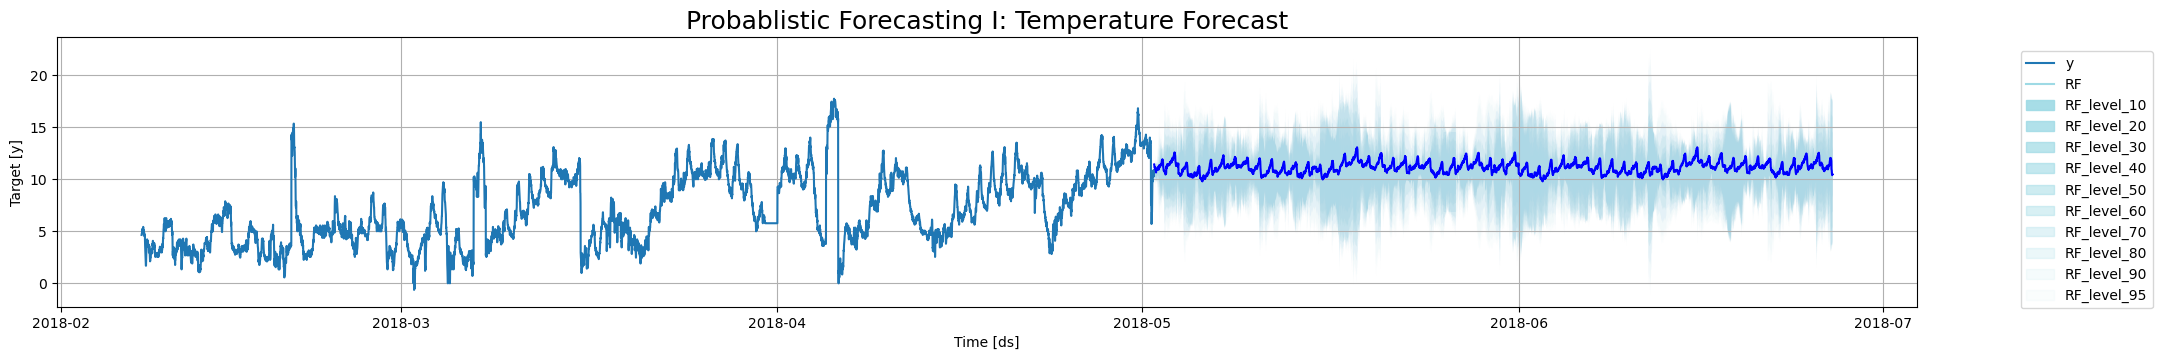

<Figure size 640x480 with 0 Axes>

In [70]:
fig = plot_series(df=uni,
            forecasts_df=rf_mstl_ensemble.assign(uid=1,
                                                 ds=test_pred_rf.ds.values),
            id_col='uid',
            models=['RF'],
            max_insample_length=8000,
            palette='tab20',
            level=quantiles,
            engine='matplotlib'
            
            )


import matplotlib.pyplot as plt

# Assuming 'fig' is your figure object and the first axis is the one we want to modify
ax = fig.axes[0]

# Change the color of the forecast line
forecast_line = ax.lines[1]  # The forecast line is typically the second line in the plot
forecast_line.set_color('blue')

# Change the color of the quantile fill
for collection in ax.collections:
    collection.set_facecolor('lightblue')
    collection.set_edgecolor('none')

# Set the background to white
ax.set_facecolor('white')

# Update the figure
plt.draw()

ax.set_title('Probablistic Forecasting I: Temperature Forecast',fontsize=18)

fig

In [71]:
test_sub = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/probabilistic-forecasting-i-temperature/sample_submission.csv')

In [72]:
make_submission(rf_mstl_ensemble.filter(like='RF'),model='RF').to_csv('final_submission.csv')